# Using Machine Learning to Predict NBA shot analysis

In this machine learning model, I will be using the NBA shot logs dataset from kaggle to do analysis and develop a model to answer some questions like what is an optimal distance to take a shot from, who are the best defenders and worst defenders and more. In the first part, I do some EDA to analyse the dataset and discover any tweaks or modifications i need to make in order to run a good model.

Then I develop some supervised learning models using linear regression, following that I develop an ensemble method supervised learning model called Adaboost.

And finally, I develop an unsupervised learning model and compare it to the other two supervised learning models.

The dataset can be found here https://www.kaggle.com/datasets/dansbecker/nba-shot-logs/

This dataset contains all shot data for the 2014-2015 season.



### EDA Procedure

In [1]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

In [2]:
filepath = '/content/sample_data/shot_logs 2.csv'

df = pd.read_csv(filepath)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  float64
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  128069 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [4]:
#lets group by player ID and see their total fg made to missed
player_fg_stats = df.groupby(['player_id', 'player_name'])['FGM'].agg(['sum', 'count']).reset_index()
player_fg_stats.columns = ['player_id','player_name', 'Total_FGM', 'Total_FGA']

player_fg_stats['Total_Percent'] = player_fg_stats['Total_FGM'] / player_fg_stats['Total_FGA']

#now lets find the highest fg% in the league whos FGA exceeds 300

filtered_players = player_fg_stats[player_fg_stats['Total_FGA'] > 300]
highest_fg_percentage_player = filtered_players.loc[filtered_players['Total_Percent'].idxmax()]
lowest_fg_percentage_player = filtered_players.loc[filtered_players['Total_Percent'].idxmin()]

print(player_fg_stats.head())
print(highest_fg_percentage_player)
print(lowest_fg_percentage_player)
#Based on this, Deandre jordan was one of the most efficient shooters in the league for 2014-2015 year


   player_id     player_name  Total_FGM  Total_FGA  Total_Percent
0        708   kevin garnett        140        301       0.465116
1        977     kobe bryant        266        713       0.373072
2       1495      tim duncan        311        627       0.496013
3       1713    vince carter         94        283       0.332155
4       1717  dirk nowtizski        377        816       0.462010
player_id                201599
player_name      deandre jordan
Total_FGM                   280
Total_FGA                   393
Total_Percent          0.712468
Name: 124, dtype: object
player_id                2550
player_name      kirk hinrich
Total_FGM                 113
Total_FGA                 314
Total_Percent        0.359873
Name: 32, dtype: object


According to this, Deandre Jordan was the best fg percent shooter at 71% and Kirk hinrich was the worst at 36% on 300+ attempts

In [5]:
#Now lets do the same but with the closest defender data to see who is the leagues best defender

def_player_fg_stats = df.groupby(['CLOSEST_DEFENDER_PLAYER_ID', 'CLOSEST_DEFENDER'])['FGM'].agg(['sum', 'count']).reset_index()
def_player_fg_stats.columns = ['CLOSEST_DEFENDER_PLAYER_ID','CLOSEST_DEFENDER', 'Total_FGM', 'Total_FGA']

def_player_fg_stats['Total_Percent'] = def_player_fg_stats['Total_FGM'] / def_player_fg_stats['Total_FGA']

def_filtered_players = def_player_fg_stats[def_player_fg_stats['Total_FGA'] > 300]

def_highest_fg_percentage_player = def_filtered_players.loc[def_filtered_players['Total_Percent'].idxmax()]
def_lowest_fg_percentage_player = def_filtered_players.loc[def_filtered_players['Total_Percent'].idxmin()]

print(def_highest_fg_percentage_player)
print(def_lowest_fg_percentage_player)

CLOSEST_DEFENDER_PLAYER_ID                201578
CLOSEST_DEFENDER              Speights, Marreese
Total_FGM                                    189
Total_FGA                                    366
Total_Percent                           0.516393
Name: 168, dtype: object
CLOSEST_DEFENDER_PLAYER_ID           2754
CLOSEST_DEFENDER              Allen, Tony
Total_FGM                             113
Total_FGA                             318
Total_Percent                    0.355346
Name: 75, dtype: object


According to this, on 300+ contested shots, Tony Allen was the best defender (35%) and Marreese Speights was the worst at 52%

In [6]:
#Lets drop some columns that we don't need
df.drop(columns=['LOCATION', 'W', 'FINAL_MARGIN', 'GAME_CLOCK', 'SHOT_NUMBER', 'PERIOD', 'SHOT_RESULT'] , inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   SHOT_CLOCK                  122502 non-null  float64
 3   DRIBBLES                    128069 non-null  int64  
 4   TOUCH_TIME                  128069 non-null  float64
 5   SHOT_DIST                   128069 non-null  float64
 6   PTS_TYPE                    128069 non-null  int64  
 7   CLOSEST_DEFENDER            128069 non-null  object 
 8   CLOSEST_DEFENDER_PLAYER_ID  128069 non-null  int64  
 9   CLOSE_DEF_DIST              128069 non-null  float64
 10  FGM                         128069 non-null  int64  
 11  PTS                         128069 non-null  int64  
 12  player_name                 128069 non-null  object 
 13  player_id     

<ipython-input-7-71a95d8ffd6e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  coor_matrix = df.corr()
<ipython-input-7-71a95d8ffd6e>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_mat = df.corr()


Best coorelation values for FGM
PTS                           0.970686
SHOT_DIST                    -0.191704
PTS_TYPE                     -0.121293
SHOT_CLOCK                    0.096855
TOUCH_TIME                   -0.045299
DRIBBLES                     -0.034390
GAME_ID                      -0.008761
player_id                    -0.005099
CLOSEST_DEFENDER_PLAYER_ID   -0.002633
CLOSE_DEF_DIST               -0.001074
dtype: float64


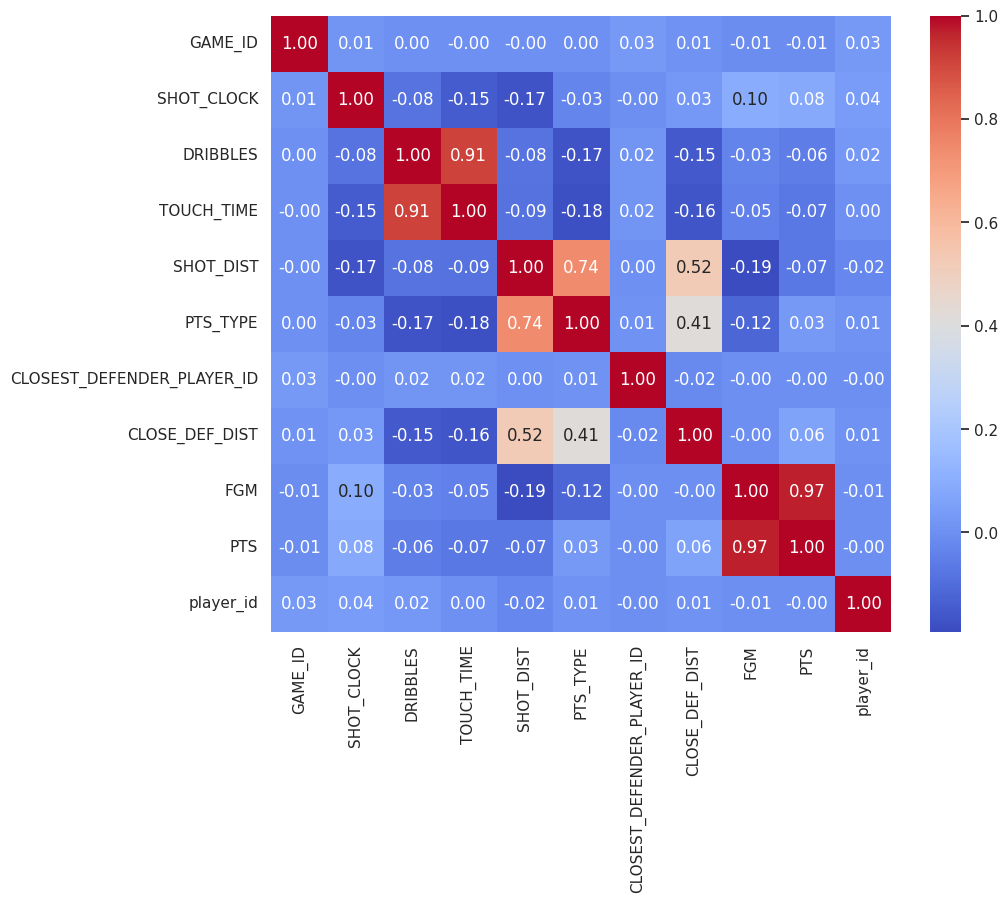

In [7]:
coor_matrix = df.corr()

ordered_correlations = coor_matrix.unstack().sort_values(ascending=False, key=abs)
ordered_correlations = ordered_correlations[abs(ordered_correlations) < 1.0]

print("Best coorelation values for FGM")
print(ordered_correlations.FGM)

cor_mat = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()




Based on the correlation matrix, we can see that there is an obvious coorelation between points and FGM but we can discard this. Next to this, we can look at shot distance being a good indicator of a shot made and the pt type (2/3).

Additionally we can also see that shot clock as coorelation too as well as touch time and dribbles but further exploration needs to be done to make this more accurate.

This is the end of the EDA phase, next section I will implement a simple linear regression model.


In [8]:
#Lets prepare our data
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

print(X_train.shape)

(102455, 14)


# Linear Regression Models

The Code below creates a multi linear model using multiple terms to predict if a FGM is 1 or 0.

In [9]:
# use best_guess_predictor as a single predictor
# build a simple linear regression model, train on the X_train portion
#Lets use the coorelation matrix and use top 5 predictors

predictors = ['SHOT_DIST', 'PTS_TYPE', 'SHOT_CLOCK', 'DRIBBLES', 'CLOSE_DEF_DIST ']
model = smf.ols(formula= 'FGM ~ ' + ' + '.join(predictors), data=X_train).fit()
result = model

#update following value according to the result
adj_R2 = result.rsquared_adj
print(adj_R2)

print(len(model.params.index))

print(result.summary())

0.051991247190609324
6
                            OLS Regression Results                            
Dep. Variable:                    FGM   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1076.
Date:                Tue, 05 Mar 2024   Prob (F-statistic):               0.00
Time:                        18:55:38   Log-Likelihood:                -68122.
No. Observations:               97999   AIC:                         1.363e+05
Df Residuals:                   97993   BIC:                         1.363e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.

Using this, we are only getting r squared value of 0.05199 which is pretty weak, lets try polynomial next


In [11]:
#Polynomial Regression model using the top 4 predictors from the corr matrix
#in this we try to figure out the best N value
predictors = ['SHOT_DIST', 'PTS_TYPE', 'SHOT_CLOCK', 'DRIBBLES', 'CLOSE_DEF_DIST ']
predictor_listP = []

for degree in range(1, 11):
    formula = 'FGM ~ SHOT_DIST'
    for n in range(2, degree + 1):
        formula += f' + np.power(SHOT_DIST, {n})'

    model = smf.ols(formula=formula, data=df).fit()

    adj_R2 = model.rsquared

    predictor_listP.append((degree, adj_R2))

predictor_listP.sort(key=lambda x: x[1], reverse=True)
print(predictor_listP)



[(9, 0.04762899901768314), (8, 0.047603162535855725), (7, 0.04722315846986114), (6, 0.04655234207254422), (5, 0.04564480869025933), (4, 0.04505696796163294), (3, 0.04381381163228204), (2, 0.03898472771933914), (1, 0.03675026277497806), (10, 0.007972759689695352)]


After using polynomial with a single column SHOT_DIST, we are able to increase the accurazy to 0.0476 which is better but still weak. At this point, we can see that the individual rows data have too much variance to see any coorelation so something needs to be done.

An idea I had is to group the data by shot clock time intervals like all data where shot clock is between 0-4s, then 4-8 etc.

Then doing this again for shot distance since those were our best two predictors.

In [12]:
#Condense the data to shot clock intervals
intervals = [(0, 4), (4, 8), (8, 12), (12, 16), (16, 18), (18, 24)]

shotClock_df = pd.DataFrame()

for interval in intervals:
    interval_start, interval_end = interval
    filtered_data = df[(df['SHOT_CLOCK'] >= interval_start) & (df['SHOT_CLOCK'] < interval_end)]
    interval_avg = filtered_data.groupby('SHOT_CLOCK').mean().reset_index()  # Calculate averages for all columns

    # Append the averaged data for the current interval to the main DataFrame
    shotClock_df = pd.concat([shotClock_df, interval_avg])



<ipython-input-12-7d2045466bc3>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg = filtered_data.groupby('SHOT_CLOCK').mean().reset_index()  # Calculate averages for all columns
<ipython-input-12-7d2045466bc3>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg = filtered_data.groupby('SHOT_CLOCK').mean().reset_index()  # Calculate averages for all columns
<ipython-input-12-7d2045466bc3>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns 

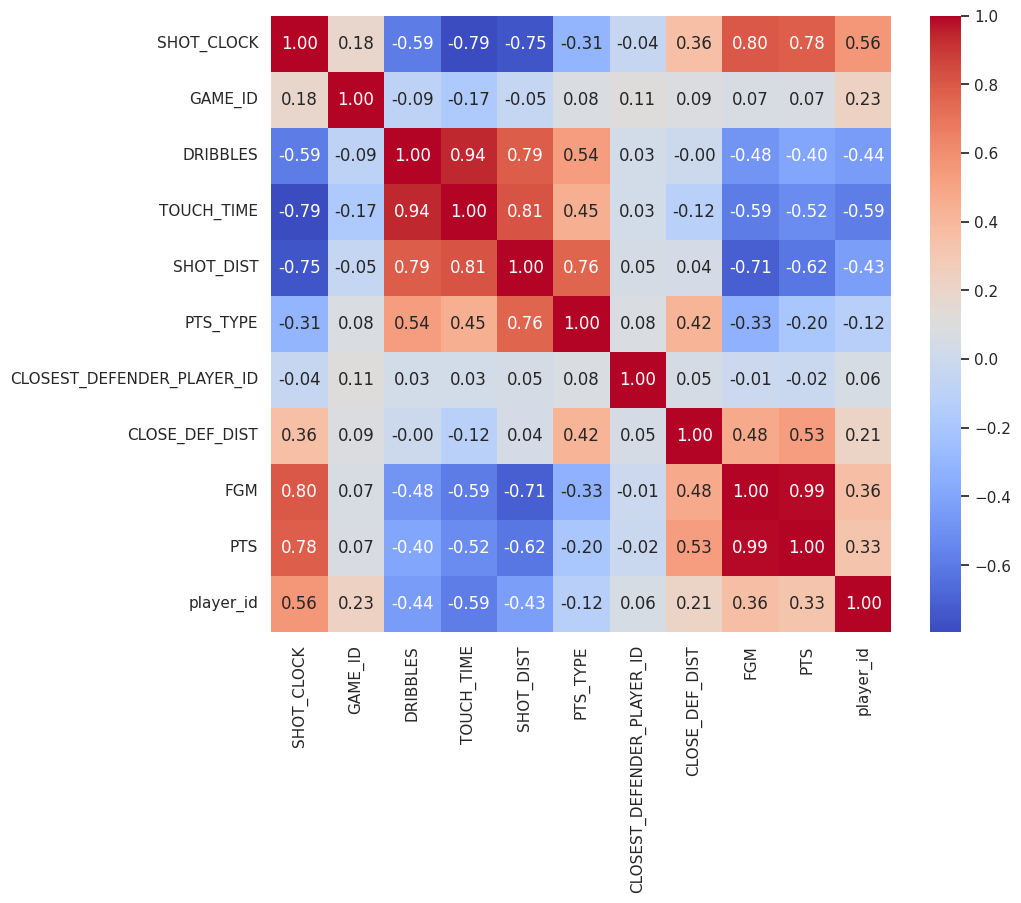

In [13]:
cor_mat = shotClock_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [82]:
shot_X_train, shot_X_test = train_test_split(shotClock_df, test_size=0.2, random_state=42)

predictors = ['SHOT_DIST', 'PTS_TYPE', 'SHOT_CLOCK', 'DRIBBLES', 'CLOSE_DEF_DIST ']
model_shot = smf.ols(formula= 'FGM ~ ' + ' + '.join(predictors), data=shot_X_train).fit()
result_shot = model_shot
print(shot_X_train.shape)

#update following value according to the result
adj_R2 = result_shot.rsquared_adj
print(adj_R2)

print(len(model_shot.params.index))

print(result_shot.summary())

print(shot_X_train.shape)

(192, 11)
0.7912030472480144
6
                            OLS Regression Results                            
Dep. Variable:                    FGM   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     145.8
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           2.26e-62
Time:                        22:32:22   Log-Likelihood:                 371.00
No. Observations:                 192   AIC:                            -730.0
Df Residuals:                     186   BIC:                            -710.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept    

Now, doing this we get a much stronger r squared value of 0.79 since we have grouped the shot clock in 6 second intervals. Next, lets try this again using the shot distance. In the NBA theres a wide range of shot distances that are common and less common so to find appropriate intervals, I will plot a histogram and decide accordingly.

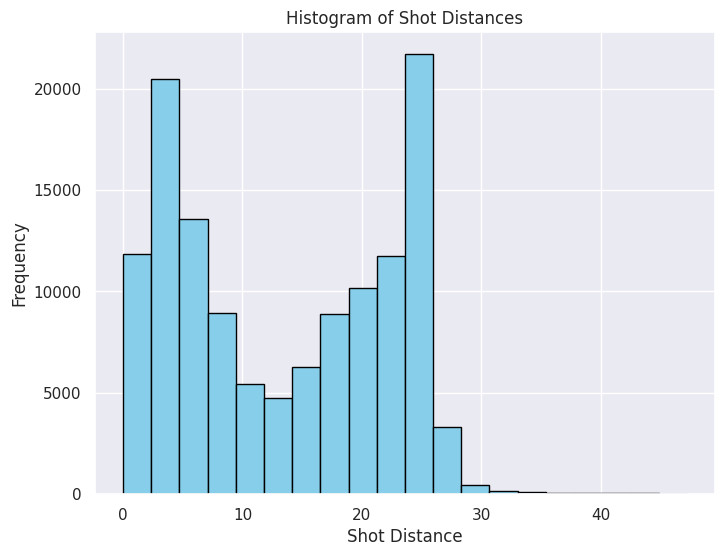

In [59]:
plt.figure(figsize=(8, 6))  # Set the figure size
plt.hist(df['SHOT_DIST'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Shot Distances')
plt.xlabel('Shot Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Using this histogram, we can the intervals the following: 0 to 5, 5 to 10, 10 to 15, 15 to 20, 20-25, and 25+

In [14]:
#Condense the data to shot distance intervals
intervals_dist = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 40)]

shotDist_df = pd.DataFrame()

for interval in intervals:
    interval_start, interval_end = interval
    filtered_data = df[(df['SHOT_DIST'] >= interval_start) & (df['SHOT_DIST'] < interval_end)]
    interval_avg = filtered_data.groupby('SHOT_DIST').mean().reset_index()  # Calculate averages for all columns

    # Append the averaged data for the current interval to the main DataFrame
    shotDist_df = pd.concat([shotDist_df, interval_avg])

dist_X_train, dist_X_test = train_test_split(shotDist_df, test_size=0.2, random_state=42)

predictors = ['SHOT_DIST', 'PTS_TYPE', 'SHOT_CLOCK', 'DRIBBLES', 'CLOSE_DEF_DIST ']
model_dist = smf.ols(formula= 'FGM ~ ' + ' + '.join(predictors), data=dist_X_train).fit()
result_dist = model_dist
print(dist_X_train.shape)

#update following value according to the result
adj_R2 = result_dist.rsquared_adj
print(adj_R2)

print(len(model_dist.params.index))

print(result_dist.summary())

print(dist_X_train.shape)


(192, 11)
0.8799214285263213
6
                            OLS Regression Results                            
Dep. Variable:                    FGM   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     280.9
Date:                Tue, 05 Mar 2024   Prob (F-statistic):           1.19e-84
Time:                        18:59:18   Log-Likelihood:                 395.40
No. Observations:                 192   AIC:                            -778.8
Df Residuals:                     186   BIC:                            -759.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept    

<ipython-input-14-52a49186ec8c>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg = filtered_data.groupby('SHOT_DIST').mean().reset_index()  # Calculate averages for all columns
<ipython-input-14-52a49186ec8c>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg = filtered_data.groupby('SHOT_DIST').mean().reset_index()  # Calculate averages for all columns
<ipython-input-14-52a49186ec8c>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns wh

Once again, we can see our theory checking out and we get a high coorelation between shot distance and fgm at 0.88 r squared value. Lets plot these two models to FGM to visualize their relationship and coorelation.

Knowing that shot distance is our best predictor, lets again reformat the data to take the averages of other columns but this time we also go back to seperating them by player so we have each players averages from each shot distance interval. Using this new data, we can build models to predict optimal shot distance areas for different players, their touch time, dribbles and more.

# Non Parametric Model

From the end of the previous section, we discovered using individual shot data was not a good predictor of making a field goal however aggregating them into clusters yielded significantly better r squared values showing clearer coorelations so in this section, we will aggregate them by player to further build our model.

In [15]:
intervals_dist = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 40)]

df_players = pd.DataFrame()

for interval in intervals_dist:
    interval_start, interval_end = interval

    filtered_data_player = df[(df['SHOT_DIST'] >= interval_start) & (df['SHOT_DIST'] < interval_end)]

    interval_avg_player_0 = filtered_data_player.groupby(['player_id', 'player_name']).mean().reset_index()
    interval_avg_player_0['SHOT_DIST'] = f'{interval_start}-{interval_end}'
    interval_avg_player_0['FGM'] = 0

    interval_avg_player_1 = filtered_data_player[filtered_data_player['FGM'] == 1].groupby(['player_id', 'player_name']).mean().reset_index()
    interval_avg_player_1['SHOT_DIST'] = f'{interval_start}-{interval_end}'
    interval_avg_player_1['FGM'] = 1

    df_players = pd.concat([df_players, interval_avg_player_0, interval_avg_player_1])


# Display the averaged data
df_players.drop(columns=['CLOSEST_DEFENDER_PLAYER_ID', 'GAME_ID'] , inplace=True)
print(df_players) #We will use this from now on

     player_id     player_name  SHOT_CLOCK  DRIBBLES  TOUCH_TIME SHOT_DIST  \
0          708   kevin garnett   15.765909  0.088889    0.777778       0-5   
1          977     kobe bryant   15.125000  3.457447    4.293617       0-5   
2         1495      tim duncan   13.441429  0.321429    1.296875       0-5   
3         1713    vince carter   13.268750  2.090909    2.548485       0-5   
4         1717  dirk nowtizski   12.833333  0.685185    1.981481       0-5   
..         ...             ...         ...       ...         ...       ...   
208     203957      dante exum   10.504545  1.086957    1.782609     25-40   
209     203960  jakarr sampson   11.100000  1.000000    1.775000     25-40   
210     204014    damjan rudez   11.850000  0.083333    1.200000     25-40   
211     204037     travis wear    1.200000  2.000000    2.800000     25-40   
212     204060      jon ingles   10.033333  0.500000    1.616667     25-40   

     PTS_TYPE  CLOSE_DEF_DIST  FGM       PTS  
0    2.000000   

<ipython-input-15-9ccba705e32a>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg_player_0 = filtered_data_player.groupby(['player_id', 'player_name']).mean().reset_index()
<ipython-input-15-9ccba705e32a>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interval_avg_player_1 = filtered_data_player[filtered_data_player['FGM'] == 1].groupby(['player_id', 'player_name']).mean().reset_index()
<ipython-input-15-9ccba705e32a>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_onl

In [16]:
#Change shot dist values to numerical values so the model can understand it
shot_dist_mapping = {
    '0-5': 1,
    '5-10': 2,
    '10-15': 3,
    '15-20': 4,
    '20-25': 5,
    '25-40': 6
}

df_players['SHOT_DIST'] = df_players['SHOT_DIST'].replace(shot_dist_mapping)
print(df_players)

     player_id     player_name  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  \
0          708   kevin garnett   15.765909  0.088889    0.777778          1   
1          977     kobe bryant   15.125000  3.457447    4.293617          1   
2         1495      tim duncan   13.441429  0.321429    1.296875          1   
3         1713    vince carter   13.268750  2.090909    2.548485          1   
4         1717  dirk nowtizski   12.833333  0.685185    1.981481          1   
..         ...             ...         ...       ...         ...        ...   
208     203957      dante exum   10.504545  1.086957    1.782609          6   
209     203960  jakarr sampson   11.100000  1.000000    1.775000          6   
210     204014    damjan rudez   11.850000  0.083333    1.200000          6   
211     204037     travis wear    1.200000  2.000000    2.800000          6   
212     204060      jon ingles   10.033333  0.500000    1.616667          6   

     PTS_TYPE  CLOSE_DEF_DIST  FGM       PTS  
0   

In [17]:

#Create train and test data to predict FGM
features = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'PTS_TYPE', 'SHOT_DIST','CLOSE_DEF_DIST']
target = 'FGM'

df_players_cleaned = df_players.dropna(subset=features + [target])

X = df_players_cleaned[features]
y = df_players_cleaned[target]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

print(x_train.shape)
print(x_test.shape)

(2384, 6)
(795, 6)


Now that I have clustered the data, I am ready to implement a non parametric model below. First I will build some helper functions to assist with calculating precision and recall.

In [18]:
import math
import pickle
import gzip
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# importing all the required libraries

from math import exp
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

Here are some functions to help with the decision tree solver

In [19]:
def build_dt(data_X, data_y, max_depth = None, max_leaf_nodes =None):
  dtc = DecisionTreeClassifier(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
  dtc.fit(data_X, data_y)

  return dtc

def calculate_precision(y_true, y_pred, pos_label_value=1.0):
    true_pos = 0
    false_pos = 0

    for true, pred in zip(y_true, y_pred):
        if (true == pos_label_value and pred == pos_label_value):
            true_pos = true_pos + 1

        elif (true != pos_label_value and pred == pos_label_value):
            false_pos = false_pos + 1

    if ((true_pos + false_pos) > 0):
        precision = true_pos / (true_pos + false_pos)
    else:
        precision = 0.0

    return precision

def calculate_recall(y_true, y_pred, pos_label_value=1.0):

    true_pos = 0
    false_neg = 0

    for true, pred in zip(y_true, y_pred):
        if (true == pos_label_value and pred == pos_label_value):
            true_pos = true_pos + 1

        elif (true == pos_label_value and pred != pos_label_value):
            false_neg = false_neg + 1

    if ((true_pos + false_neg) > 0):
        recall = true_pos / (true_pos + false_neg)
    else:
        recall = 0.0

    return recall


Below is a code creating a decision tree classifier using max_depth of 4 which yields a 53.8% accuracy which is slightly better than our previous one. Next I will run with multiple max depth and max leaf nodes to see if I can get an improvement

In [20]:
from sklearn.metrics import accuracy_score, classification_report

modelD2 = build_dt(x_train, y_train, max_depth=4)
y_predD2 = modelD2.predict(x_test)

precisionD2 = calculate_precision(y_test, y_predD2)
recallD2 = calculate_recall(y_test, y_predD2)

tree_depthD2 = modelD2.tree_.max_depth

accuracy = accuracy_score(y_test, y_predD2)

print("The precision of this model is " + str(precisionD2))
print("THe recall of this model is " + str(recallD2))
print("The accuracy of this model is " + str(accuracy))

The precision of this model is 0.5782122905027933
THe recall of this model is 0.5073529411764706
The accuracy of this model is 0.5572327044025157


In [100]:
best_precision = 0
best_recall = 0
best_accuracy = 0
best_max_depth = 0
best_max_leaf_nodes = 0

for max_depth in range(1, 30):
    for max_leaf_nodes in range(2, 30):
        model = build_dt(x_train, y_train, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes)
        y_pred = model.predict(x_test)

        precision = calculate_precision(y_test, y_pred)
        recall = calculate_recall(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)

        if precision > best_precision:
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy
            best_max_depth = max_depth
            best_max_leaf_nodes = max_leaf_nodes

print("best max depth " + str(best_max_depth))
print("best max leaf nodes " + str(best_max_leaf_nodes))
print("best accuracy " + str(best_accuracy))

best max depth 3
best max leaf nodes 8
best accuracy 0.5484276729559748


Using this, we discover that the best optimal max depth is 3 and max leaf nodes is 7 giving us an accuracy of 53.96, almost 4% better than random. Next section we will explore ensemble methods to try and improve this accuracy. Now that we have this model, I will try to further improve this model in the next section by using an ensemble model called Adaboost.


# Further Improvement of the model using ensemble method (AdaBoost)


In [21]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn import tree
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
%matplotlib inline



Below are some helper functions as well as the AdaBoost model implementaiton.

In [22]:
#For this I will build an adaboost model

class AdaBoost:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3), random_state=1234):

        np.random.seed(42)

        self.n_learners = n_learners
        self.base = base
        self.alpha = np.zeros(self.n_learners)
        self.learners = []

    def fit(self, X_train, y_train):

        w = np.ones(len(y_train), dtype = np.float128)
        w /= np.sum(w)

        for i in range(self.n_learners):
            h = clone(self.base)
            h.fit(X_train, y_train, sample_weight=w)
            y_pred = h.predict(X_train)
            err = self.error_rate(y_train, y_pred, w)

            alpha = 0.5 * np.log((1-err)/err)

            self.alpha[i] = alpha
            self.learners.append(h)

            w *= np.exp(-alpha * y_train * y_pred)
            w /= np.sum(w)


        return self

    def error_rate(self, y_true, y_pred, weights):

        misclass = 0
        for yt, yp, w in zip(y_true, y_pred, weights):
            if yt != yp:
                misclass = misclass + w

        er = misclass / np.sum(weights)
        return er


    def predict(self, X):
        yhat = np.zeros(X.shape[0])

        for i in range(self.n_learners):
            pred = self.learners[i].predict(X)
            yhat += self.alpha[i] * pred

        return np.sign(yhat)


    def score(self, X, y):
        y_pred = self.predict(X)

        return np.mean(y_pred == y)


    def staged_score(self, X, y):

        scores = []
        preds = np.zeros(len(y))

        for alpha, learner in zip(self.alpha, self.learners):
            preds += alpha * learner.predict(X)
            score = np.mean(np.sign(preds) == y)
            scores.append(score)

        return np.array(scores)

In [23]:
adaModel = AdaBoost(n_learners=50, base=DecisionTreeClassifier(max_depth=3, max_leaf_nodes=7)).fit(x_train, y_train)

train_predict = adaModel.predict(x_train)
print(train_predict)

[0. 0. 1. ... 1. 1. 0.]


[0.53962264 0.5408805  0.5408805  0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623 0.54339623
 0.54339623 0.54339623]
[0.58766779 0.59479866 0.59479866 0.59563758 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597 0.59689597
 0.59689597 0.59689597 0.59689597 0.59

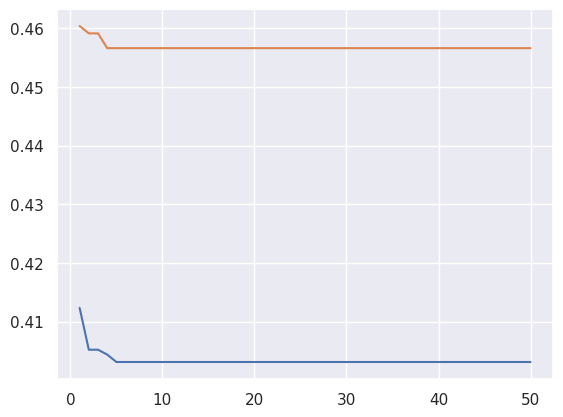

In [ ]:
train_score = adaModel.staged_score(x_train, y_train)
test_score = adaModel.staged_score(x_test, y_test)

plt.plot(range(1, len(train_score) + 1), 1 - train_score, label='Train Set')
plt.plot(range(1, len(test_score) + 1), 1 - test_score, label='Test Set')
print(test_score)
print(train_score)

plt.show()

Finally, we can see that the adaboost has brought up the training accuracy to around 60% while testing accuracy has gone up to 55% which althoug is a small increment, it has gotten better from the previous model.

Up until now, I have only implemented supervised learning algorithms but for the final section. I will implement an unsupervised learning algorithm and compare the results. the best supervised learning model (AdaBoost).

## Unsupervised Learning Model

In this section, I will implement an unsupervised algorithm using the aggregated data of shot distance and players which yielded a test score of 0.54 and train score of 0.59.

More specifically, I will use clustering techniques to identify inherent patterins or groupings within the data and to do this, I will be implementing the k-means clustering model below. Since our target variable is whether a field goal is made or not, there will be 2 clusters we need to seperate.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


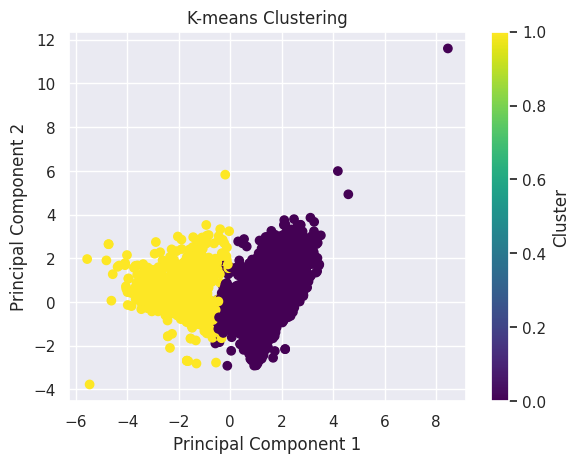

In [24]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_concat = pd.concat([x_train, x_test])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_concat)


k = 2
kmeans = KMeans(n_clusters=k, random_state=5)
kmeans.fit(X_scaled)

# Predict cluster labels
cluster_labels = kmeans.predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

After applying the k-means algorithm, I needed a way to visualise the clustered results however since there are more than 2 features being used, it is difficult to visualise the higher dimension data.

To overcome this issue, I needed to reduce the dimensionality and to do this, I used principal component analysis which made the results easier to plot which you can see above there is a clear split.

In [25]:
#Measure the accuracy of k means

accuracy_clustering = accuracy_score(y, cluster_labels)
print("Accuracy of clustering:", accuracy_clustering)

Accuracy of clustering: 0.5058194400754954


This model using supervised learning with k means is yielding an accuracy of 50.58% which is worse than the supervised learning models and only slightly above a random guess. My final attempt was to do some additional dimensionality reduction by removing some features and I expeirmented with dropping various features and landed on the best accuracy to be when I drop PTS_TYPE and CLOSE_DEF_DIST

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


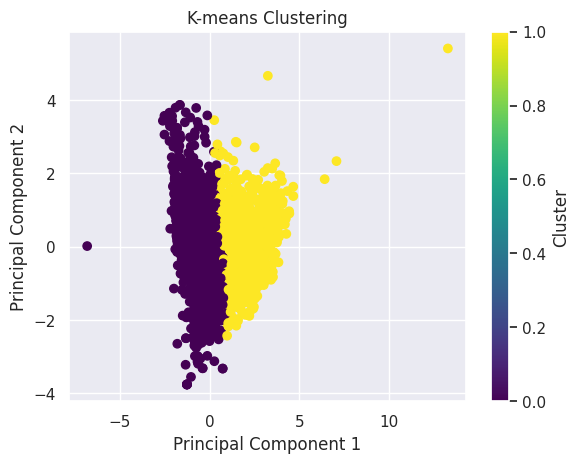

In [156]:
#lets drop some columns and try to run k means
# ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'PTS_TYPE', 'SHOT_DIST','CLOSE_DEF_DIST']
reduce_cols = ['PTS_TYPE', 'CLOSE_DEF_DIST']
x_train_reduced = x_train.drop(columns=reduce_cols)
x_test_reduced = x_test.drop(columns=reduce_cols)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_concat = pd.concat([x_train_reduced, x_test_reduced])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_concat)

# Perform K-means clustering
k = 2
kmeans = KMeans(n_clusters=k, random_state=5)
kmeans.fit(X_scaled)

cluster_labels2 = kmeans.predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels2, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [157]:
accuracy_clustering = accuracy_score(y, cluster_labels2)
print("Accuracy of clustering:", accuracy_clustering)

Accuracy of clustering: 0.5155709342560554


After this, I got an accurazy of 0.5155 which is slightly better than the standard 50% however not as good as the supervised learning models from earlier.

# Conclusion

To summarize, we first started with EDA where we took the dataset and plotted a coorelation matrix as well as a heat map to visualize the coorelation between the variables. We saw some coorleation with the shot distance then shot clock however it was very little.

After merging the shot clock and shot distance into clusters, I was able to find a much higher coorelation and decided to use that as our model dataset.

By combining the shot distance into 6 distinct clusters, the data was modified to have rows containing all the averages of each player in each shot distance interval and was seperated by the FGM being 0 or 1.

This model was first put through a logistic regression model to get a 52% accuracy.

TO improve this, I used a decision tree classifier. To determine the optimal max depth and max leaf nodes, i iterated through models combining all combinations from 1 to 30 and landed on max depth to be 3 and max leaf nodes to be 7. Using this, I was able to improve the accuracy to 53.4% which was slightly better than the 52% from logistic regression.

This was still not enough, so finally I implemented an adaboost model that was shown in lab 5. Using the previous max depth and max leaf nodes combined with adaboost, I was able to improve the accuracy to 60% and the trst accuracy to 54 which was a significant improvement from before.

After implementing all these supervised algorithms, I decided to also try implementing an unsupervised learning model through k-means clustering. Since the target variable is binary (made shot or missed shot), I had to use 2 clusters as my hyperparamater and using this I got an initial scote of 50.45 which is worse than the best suprvised model I made (60%). To improve this model, I tried to apply PCA for dimensionality reduction as well as transforming the data to a scaler fit which improved it to 51.55% which although not great, its still better than 50% random chance.

All in all, I discovered that having labeled data and developing supervised learning model allowed for an overall accuracy of 60% on the training dataset and compariatvely an accuracy of 51.5% when using unsupervised learning with unlabaled data. In the long run this 51.5% can go a long way in terms of predicting shots made or not using only a few pieces of information like shot clock and shot distance. Given that we are using unlabeled data, this is a decent result.

This concludes the project however further development can be done to try and improve it even more. For example seperating it by the player can isolate bad inefficient players from the better ones to create less variance and make it easier to predict.



